***Parameter Definitions***

In [1]:
nx, ny, nz              = 32, 32, 10                     # Spatial Dimension
m                       = 20                             # Number of Patterns
dd_factor               = 2                              # Detector Downsampling Factor

Loading Data

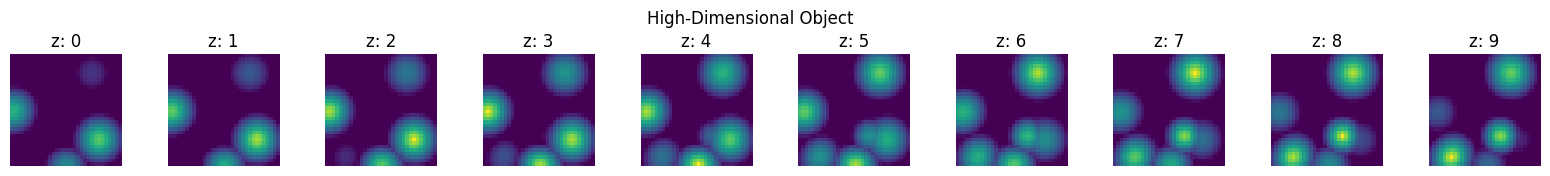

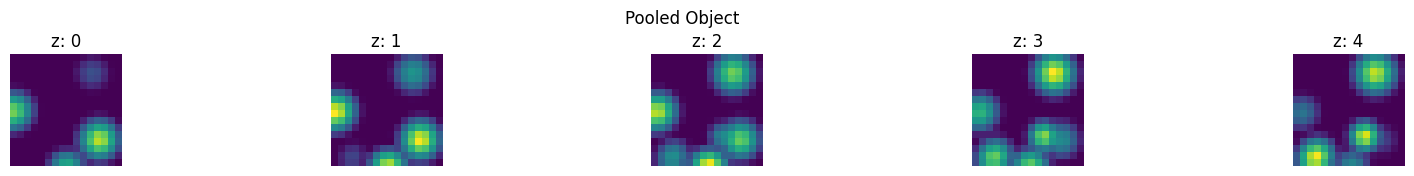

Read Object Parameters
--------------------------
Spatial Dimension	: 32×32×10
Reduced Dimension	: 16×16×5
Raw Data Type		: Nothing
Device			: cpu



In [2]:
from libs.forward_lib.read_data import ReadData

# Initialize the Read Data Model
RD = ReadData(nx, ny, nz)

# Loading Cellular Data
RD.load_object("synthetic_bead")

# Visualizing the original Data
RD.visualize_data(is_orginal=True, n_planes=10)

# Average Pooling Operation To Reduce Dimension
RD.reduce_dimension()

# Visualize the Dimension Reduced Data
RD.visualize_data(n_planes=5)
print(RD)

Linearized Model

In [3]:
from libs.forward_lib.linearized_process import LinearizedModel

# # Initialize the Linear Model
# LM = LinearizedModel(nx,ny,nz, m, dd_factor, init_call=True)

# # Better Understand the Model Parameters
# print(LM)

# # Calculate the Dimension Reduced Matrix
# LM.approximate_A()

# # LM.save_original_matrix()
# # LM.save_original_matrix(original_=False)

#---------LOAD A SAVED MOEDL----------------------------------------#

LM = LinearizedModel(nx,ny,nz, m, dd_factor, init_call=False)
LM.load_matrix(it = 0, original_ = True)
print(LM)

Linearized Model Specifications
----------------------------------------------
NA 				: 1.2
Space Dimension 		: 1.600um × 1.600um × 0.500um
Analog Voxel Size 		: 0.05um × 0.05um × 0.05um
Reduced Voxel Size 		: 0.1um × 0.1um × 0.1um
Original Shape 			: 32 × 32 × 10
Reduced Shape 			: 16 × 16 × 5
DMD Patterns 			: 20
Measurement Plane		: 1
Detector Pool size 		: 2×2
Computational Device 		: cpu


Prepare X,A,y for twist

In [4]:
X = RD.X.numpy()
X = X.reshape(nx*ny*nz, 1)

FM = LM.A.numpy()

In [5]:
import numpy as np

def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

y_clean = FM@X

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB)

Run twist

In [6]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_clean

# absAty = np.abs(utils.AT(y, FM, nx, ny, nz))
# tau = 1e-7*np.max(absAty) # Regularization parameter
tau = 1e0 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'TV' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-3 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=0)

Visualize results

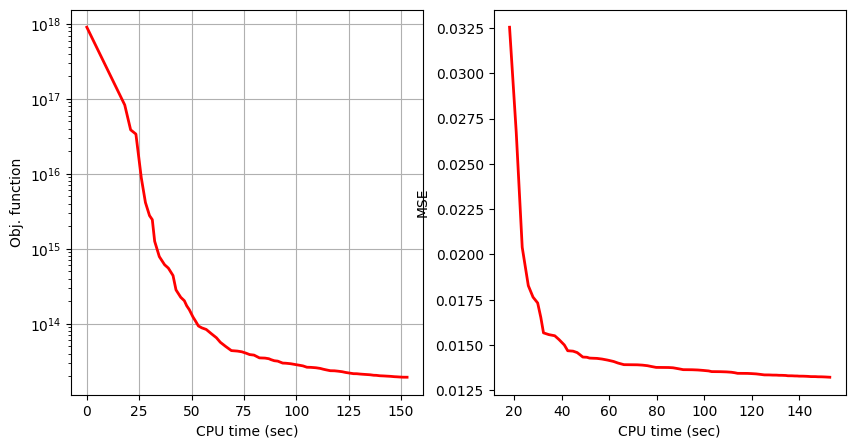

TwIST CPU time: 152.84375
MSE Loss: 1.3220e-02


In [7]:
utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

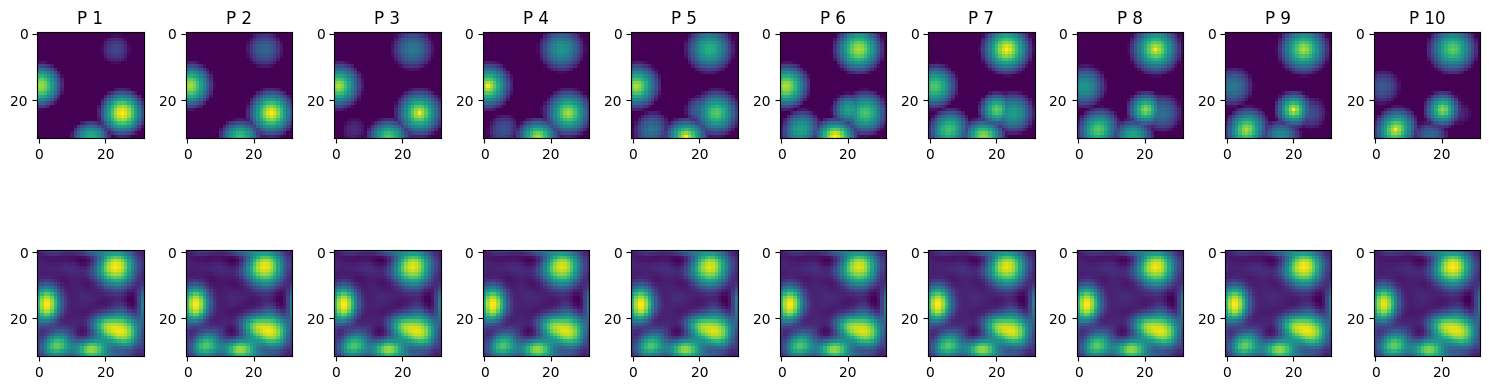

plane 1 | SSIM = 0.4426 | PSNR = 13.0259 dB
plane 2 | SSIM = 0.5000 | PSNR = 13.7812 dB
plane 3 | SSIM = 0.6275 | PSNR = 15.4186 dB
plane 4 | SSIM = 0.7386 | PSNR = 17.3519 dB
plane 5 | SSIM = 0.8208 | PSNR = 19.5216 dB
plane 6 | SSIM = 0.8391 | PSNR = 20.6374 dB
plane 7 | SSIM = 0.7792 | PSNR = 18.8732 dB
plane 8 | SSIM = 0.7037 | PSNR = 16.2514 dB
plane 9 | SSIM = 0.6334 | PSNR = 14.2431 dB
plane 10 | SSIM = 0.5810 | PSNR = 13.1283 dB


In [8]:
ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(0,nz,1))